久保拓弥『データ解析のための統計モデリング入門』をJuliaでやってみます。

* 久保さんの書籍ページ：http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html
* Amazon.co.jp：https://amzn.to/2Cg5vDJ

# 第5章 GLMの尤度比検定と検定の非対称性

In [1]:
using CSV
using DataFrames
using GLM
using Plots
using Distributions

## 5.2 尤度比検定の例題：逸脱度の差を調べる

In [2]:
d = CSV.read("data3a.csv");
fit1 = glm(@formula(y ~ 1), d, Poisson(), LogLink());
fit2 = glm(@formula(y ~ x), d, Poisson(), LogLink());

**尤度比**（_likelihood ratio_）を対数化して-2をかけたものが逸脱度の差$\Delta D$になる。
$$ \frac{L_1^\ast}{L_2^\ast} $$
$$ \Delta D_{1,2} = -2\times\left(\log L_1^\ast - \log L_2^\ast\right) $$

In [3]:
D1 = -2 * loglikelihood(fit1)
D2 = -2 * loglikelihood(fit2)
deltaD = D1 - D2   # deviance(fit1) - deviance(fit2) でも同じ

4.5139410788519285

この4.5という値の大きさが十分なのかどうかをどうやって確認するの？というのが、この後の中心的な話題。

## 5.4 帰無仮説を棄却するための有意水準

### 5.4.1 方法(1) 汎用性のあるパラメトリックブートストラップ法（p.102）



In [4]:
deviance(fit1) - deviance(fit2)

4.513941078851829

In [5]:
d[:y_rnd] = rand(Poisson(mean(d[:y])), 100)

100-element Array{Int64,1}:
  6
 10
  3
  6
  5
  7
  6
  6
  7
  5
 11
 15
  7
  ⋮
  8
 10
  7
  9
  7
  6
  6
 10
 10
  7
  3
  7

In [6]:
d

,y,x,f,y_rnd
,Int64⍰,Float64⍰,String⍰,Int64
1,6,8.31,C,6
2,6,9.44,C,10
3,6,9.5,C,3
4,12,9.07,C,6
5,10,10.16,C,5
6,4,8.32,C,7
7,9,10.61,C,6
8,9,10.06,C,6
9,9,9.93,C,7


In [7]:
fit1 = glm(@formula(y_rnd ~ 1), d, Poisson(), LogLink())
fit2 = glm(@formula(y_rnd ~ x), d, Poisson(), LogLink())
deviance(fit1) - deviance(fit2)

0.9795550179359509

これを1000回くらい繰り返して、ランダム生成したデータの逸脱度の差の平均や標準偏差をみる。単純な方法は以下の`for`を使うやり方。

In [8]:
N = 1000
dd12 = zeros(N)
for n=1:N
    d[:y_rnd] = rand(Poisson(mean(d[:y])), 100)
    fit1 = glm(@formula(y_rnd ~ 1), d, Poisson(), LogLink())
    fit2 = glm(@formula(y_rnd ~ x), d, Poisson(), LogLink())
    dd12[n] = deviance(fit1) - deviance(fit2)
end

p.104のコードをJuliaで書くと以下のようになるだろうか。`replicate()`の代わりにarray comprehensionを使った。

In [9]:
function get_dd(d)
    n_sample = nrow(d)
    y_mean = mean(d[:y])
    d[:y_rnd] = rand(Poisson(mean(d[:y])), 100)
    fit1 = glm(@formula(y_rnd ~ 1), d, Poisson(), LogLink())
    fit2 = glm(@formula(y_rnd ~ x), d, Poisson(), LogLink())
    return(deviance(fit1) - deviance(fit2))
end

function pb(d, n_bootstrap)
    [get_dd(d) for n=1:n_bootstrap]
end

N = 1000
dd12 = pb(d, N)

1000-element Array{Float64,1}:
 0.03503911493257306 
 2.16551712244987    
 0.18417904336557456 
 2.9710552248369595  
 0.03029112775013232 
 4.854771978557437e-5
 0.580461177384251   
 0.8108954861038455  
 0.002174093469250238
 0.07239236495857426 
 0.4371866103910236  
 0.30143412744338605 
 0.19640750581336874 
 ⋮                   
 0.009246001972172735
 0.08132731498284329 
 0.737911483088638   
 0.28999534747438815 
 0.06477951930165204 
 2.4985931415139646  
 0.3102158555185781  
 0.9592464035310684  
 0.00981962853391849 
 0.05134126542147044 
 0.03052263022394186 
 1.2774884716550616  

In [10]:
describe(dd12)

Summary Stats:
Mean:           0.937513
Minimum:        0.000013
1st Quartile:   0.087458
Median:         0.422597
3rd Quartile:   1.331941
Maximum:        7.498798
Length:         1000
Type:           Float64


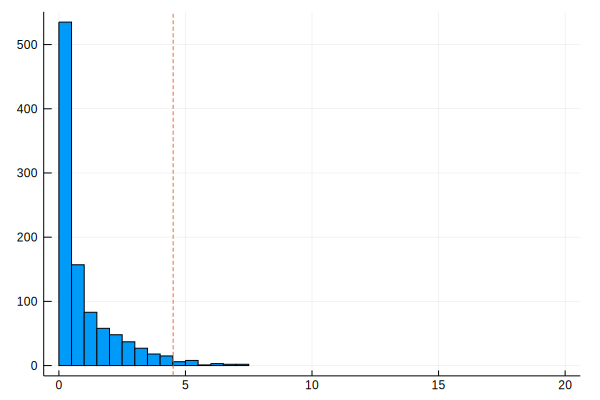

In [11]:
histogram(dd12, xlim=[0, 20], legend=false)
vline!([deltaD], linestyle=:dash)

In [12]:
sum(dd12 .>= deltaD)

22

In [13]:
p_value = sum(dd12 .>= deltaD) / length(dd12)

0.022

In [14]:
α = 0.05
quantile(dd12, 1-α)

3.6507388924380972

有意水準5%では上記の数値くらいまでの逸脱度の差は「よくある差」だと判断できる。

### 3.4.2 方法(2) カイ二乗分布を使った近似計算法

JuliaにRのようなANOVAは無さそうなので、コード例をそのままJuliaに移植することはできない。でもカイ二乗分布の累積分布関数を使ってp値を求めることはできる。

In [15]:
fit1 = glm(@formula(y ~ 1), d, Poisson(), LogLink())
fit2 = glm(@formula(y ~ x), d, Poisson(), LogLink())
dd12 = deviance(fit1) - deviance(fit2)
1 - cdf(Chisq(1), dd12)

0.03361969100898521